<a href="https://colab.research.google.com/github/KurArtem/JSON-java/blob/master/Neurals2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from google.colab.patches import cv2_imshow
link = "/content/drive/My Drive/Datasets"
!ls "/content/drive/My Drive/Datasets"
drive.mount('/content/drive')
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from skimage import io
import numpy as np
import random as rnd
import os
import zipfile
import math
from sklearn.model_selection import train_test_split

cats  Cat.zip  dogs  Dog.zip  Images  TCats  TDogs
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class VNetwork:
  def __init__(self):
    self.__outputs = list()
    self.input_neurons_count = 16
    self.layers = 3
    self.x_train = []
    self.y_train = []
    self.x_test = []
    self.y_test = []
    self.neurons = []
    self.__create_samples()
    self.__initialize_neurons()

  def activation(self, x):
    return round(1 / (1 + math.exp(-x)))

  def diff_act(self, x):
    return self.activation(x) * (1 - self.activation(x))

  def train(self, dbg, speed, ages = 10000):
    loss_values = []
    hitrate_values = []
    ages_values = []
    for i in range(ages):
      hits = 0
      loss = 0
      preds = []
      start = self.neurons
      y_true = []
      for rl in range(0, len(self.y_train)):
        if (dbg):
          print(rl, ") ", self.neurons)
        self.__overwrite_rule_outputs()
        y_predicted = self.get_predicted_value(0, 0, self.x_train[rl])
        preds.append(y_predicted)
        y_true.append(self.y_train[rl])
        curr_loss = y_predicted - self.y_train[rl]
        if (y_predicted == self.y_train[rl]):
          hits = hits + 1
        else:
          for layer_pos in range(len(self.neurons)):
            for neu_pos in range(len(self.neurons[layer_pos])):
              output = self.__outputs[layer_pos][neu_pos]
              for weight_id in range(len(self.neurons[layer_pos][neu_pos])):
                if (output == 1):
                  self.neurons[layer_pos][neu_pos][weight_id] = self.neurons[layer_pos][neu_pos][weight_id] - 1 * speed
                else:
                  self.neurons[layer_pos][neu_pos][weight_id] = self.neurons[layer_pos][neu_pos][weight_id] + 1 * speed
        loss += np.square(curr_loss)
      loss = np.sqrt(loss) / len(y_true)
      loss_values.append(loss)
      ages_values.append(i + 1)
      hit_rate = hits / len(self.y_train)
      hitrate_values.append(hit_rate)
      if (hit_rate >= 0.9 and loss <= 0.2):
        break
      if (dbg):
        print("\n\nat the ", i + 1, " age:")
        print("Предсказанные\n", preds, "\nИстинные\n", self.y_train)
        print("hitrate: ", hit_rate)
        print("loss: ", loss)
        print("weights\n", self.neurons)
    plt.plot(ages_values, hitrate_values)
    plt.show()
    plt.plot(ages_values, loss_values)
    plt.show()
    print("\n")

  def get_predicted_value(self, layer, pos, rule):
    outputs = list()
    if (layer < 1):
      for neu_id in range(len(self.neurons[layer + 1])):
        outputs.append(self.get_predicted_value(layer + 1, neu_id, rule))
    else:
      outputs = list(np.reshape(rule, 256))
    outputs.append(1)
    w = self.neurons[layer][pos]
    x = np.dot(outputs, w)
    its_output = self.activation(x)
    self.__outputs[layer][pos] = its_output

    return its_output
  
  def test(self):
    loss = 0
    hits = 0
    for sample in range(len(self.x_test)):
      y_predicted = self.get_predicted_value(0, 0, self.x_test[sample])
      if (y_predicted == self.y_test[sample]):
        hits += 1
    hit_rate = hits / len(self.y_test)
    print("Test split results: hitrate: ", hit_rate)

  def __overwrite_rule_outputs(self):
    self.__outputs = list()
    for layer_id in range(len(self.neurons)):
      self.__outputs.append([-1] * len(self.neurons[layer_id]))


  def __create_samples(self):
    cats = []
    dogs = []
    classes = []
    '''for fl1 in os.listdir('/content/drive/My Drive/Datasets/TCats'):
      cats.append(np.asarray(cv2.cvtColor(io.imread('/content/drive/My Drive/Datasets/TCats/' + fl1), cv2.COLOR_BGR2RGB)))
    for fl2 in os.listdir('/content/drive/My Drive/Datasets/dogs'):
      dogs.append(np.asarray(cv2.cvtColor(io.imread('/content/drive/My Drive/Datasets/TDogs/' + fl2), cv2.COLOR_BGR2RGB)))'''
    for i in range(1, 11):
      cats.append(np.asarray(cv2.cvtColor(io.imread('/content/drive/My Drive/Datasets/TCats/' + str(i) + ".png"), cv2.COLOR_BGR2RGB)))
      dogs.append(np.asarray(cv2.cvtColor(io.imread('/content/drive/My Drive/Datasets/TDogs/' + str(i) + ".png"), cv2.COLOR_BGR2RGB)))

    cats_test = cats[:len(cats) // 5]
    cats_train = cats[len(cats) // 5:]
    dogs_test = dogs[:len(dogs) // 5]
    dogs_train = dogs[len(dogs) // 5:]

    print(np.shape(cats_train),np.shape(cats_test),np.shape(dogs_train),np.shape(dogs_test))

    self.x_train = [*cats_train, *dogs_train]
    self.x_test = [*cats_test, *dogs_test]
    self.y_train = [*([1] * int(len(cats) * 0.8)), *([0] * int(len(dogs) * 0.8))]
    self.y_test = [*([1] * int(len(cats) * 0.2)), *([0] * int(len(dogs) * 0.2))]

    print(np.shape(self.x_train), np.shape(self.x_test), np.shape(self.y_train), np.shape(self.y_test))

    self.__remake(self.x_train, self.y_train)
    self.__remake(self.x_test, self.y_test)

  def __remake(self, images, classes):
    fig, axs = plt.subplots(1, len(classes))
    fig.set_size_inches(100, 30)
    for i in range (int(len(images) / 2)):
      first_id = rnd.randint(0, len(images) - 1)
      second_id = rnd.randint(0, len(images) - 1)
      tmp_image = images[second_id]
      images[second_id] = images[first_id]
      images[first_id] = tmp_image

      tmp_class = classes[second_id]
      classes[second_id] = classes[first_id]
      classes[first_id] = tmp_class
    
    print('post-transform images ', np.shape(images))
    print('post-transform classes', np.shape(classes))
    print(type(images[0]))

    for i in range(len(classes)):
      axs[i].imshow(images[i])

    for id in range(len(images)):
      img = images[id]
      print(np.shape(img))
      img = img[:, :, 0]
      for i in range(len(img)):
        for j in range(len(img[i])):
          if img[i][j] <= 0.5:
            img[i][j] = 0
          else:
            img[i][j] = 1
      images[id] = img

    for i in range(len(classes)):
      axs[i].imshow(images[i])
    plt.show()

    print(classes)

  def __initialize_neurons(self):
    cnt = self.input_neurons_count
    self.neurons = list()
    '''while (cnt >= 1):
      layer = list()
      for i in range(int(cnt)):
        weights = []
        if cnt == self.input_neurons_count:
          weights = list()
          for i in range(len(self.x_train[0]) ** 2): 
            weights.append(rnd.randint(-2, 10))
        else:
          for i in range(int(cnt * 2)):
            weights.append(rnd.randint(-2, 10))
        layer.append(weights)
      self.neurons.append(layer)
      cnt = cnt / 2'''
    for i in range(self.layers):
      layer = list()
      if i == 0:
        neuron = []
        for j in range(cnt):
          neuron.append(rnd.randint(-4, 6))
        neuron.append(rnd.randint(-4, 6))
        layer.append(neuron)
      elif i == self.layers - 1:
        layer = list()
        for j in range(cnt):
          neuron = []
          for k in range(len(self.x_train[0]) ** 2):
            neuron.append(rnd.randint(-4, 6))
          neuron.append(rnd.randint(-4, 6))
          layer.append(neuron)
        self.neurons.append(layer)
      else:
        layer = list()
        for j in range(cnt):
          neuron = []
          for k in range(cnt):
            neuron.append(rnd.randint(-4, 6))
          neuron.append(rnd.randint(-4, 6))
          layer.append(neuron)
        self.neurons.append(layer)
    print('Start weights:')
    for layer_id in range(len(self.neurons)):
      print(layer_id, ": ", self.neurons[layer_id])

(8, 16, 16, 3) (2, 16, 16, 3) (8, 16, 16, 3) (2, 16, 16, 3)
(16, 16, 16, 3) (4, 16, 16, 3) (16,) (4,)
post-transform images  (16, 16, 16, 3)
post-transform classes (16,)
<class 'numpy.ndarray'>
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)


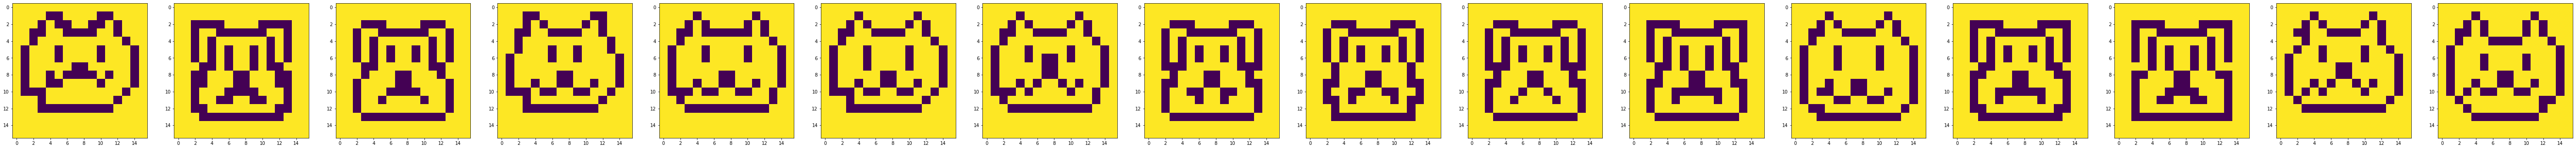

[1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1]
post-transform images  (4, 16, 16, 3)
post-transform classes (4,)
<class 'numpy.ndarray'>
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)


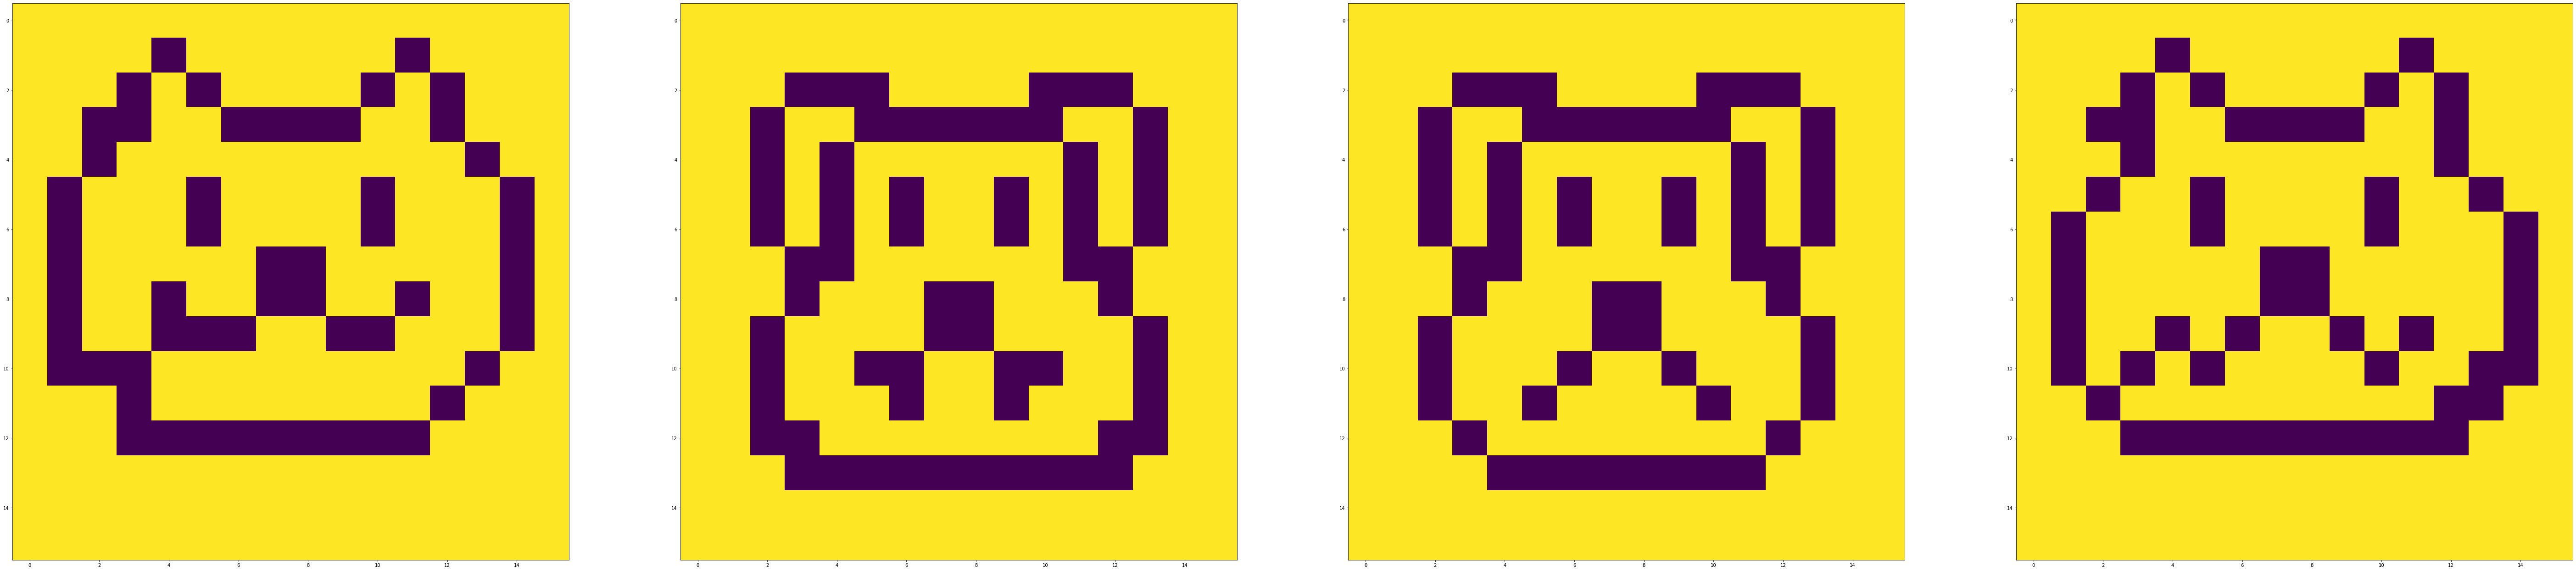

[1, 0, 0, 1]
Start weights:
0 :  [[5, 0, -1, -3, 1, 3, -4, 6, 4, -2, 6, -3, -2, -2, 1, 0, -2], [5, -1, 2, 0, 5, 1, 6, 1, -1, 3, 0, -2, -4, -4, -3, -3, 3], [-4, -2, -4, -1, 2, 2, -2, 0, -1, -1, -4, 0, 3, -2, -2, 0, -3], [1, -1, -2, 3, 2, -1, 4, -4, 3, -4, 0, 1, 1, 5, 4, -3, -4], [5, 0, 3, 4, -4, 5, -2, 0, 4, 3, -1, 4, -4, 0, -2, -2, 1], [5, -3, 2, 3, -3, 0, 0, 1, 4, 2, 2, 2, -1, 5, 3, -3, 0], [1, 3, -2, 3, 1, 0, 3, 5, 3, 0, -3, -1, 5, 2, 0, 2, -2], [-3, -3, 1, 0, -1, 1, 2, 1, 3, 1, 1, 5, 2, 6, 0, 0, 4], [-2, -1, 3, 3, 1, 6, 0, 6, 5, -4, -4, 6, -3, -3, 6, 5, -1], [6, 1, 4, 1, -1, 3, 2, 6, 4, 4, 5, -1, 0, -1, -1, 6, -3], [2, 6, -1, 4, 3, 1, -4, -1, 6, -1, -1, -3, 4, 0, -3, -3, 1], [-2, 4, 3, -4, 0, 6, 3, -2, 4, 5, 1, 5, 5, 6, 3, 4, 5], [3, 4, 0, 3, -3, -2, 3, -1, 2, 3, -2, -1, 3, -1, 0, 2, 0], [-2, -4, 2, 5, 2, -4, 4, -3, -4, -4, -4, 2, 3, -2, 3, 6, -4], [-3, 2, -2, 3, 4, -4, 4, -2, 6, -3, 4, -1, 3, -3, 2, 3, -1], [5, 0, 6, 2, 6, 1, 2, 6, -4, 6, 3, -1, 6, -1, 5, -1, 3]]
1 :  [[6, 6, -4, 5

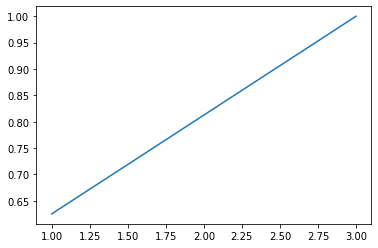

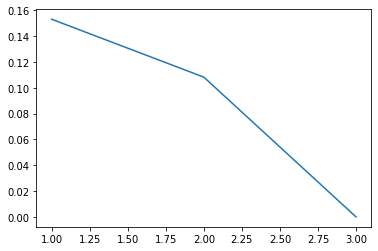



Test split results: hitrate:  1.0


In [ ]:
v_network = VNetwork()
v_network.train(True, 0.5, 100)
v_network.test()